In [75]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
from copy import deepcopy
mpl.style.use('style.mcstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plots for pipeline

(-0.5, 127.5, -0.5, 127.5)

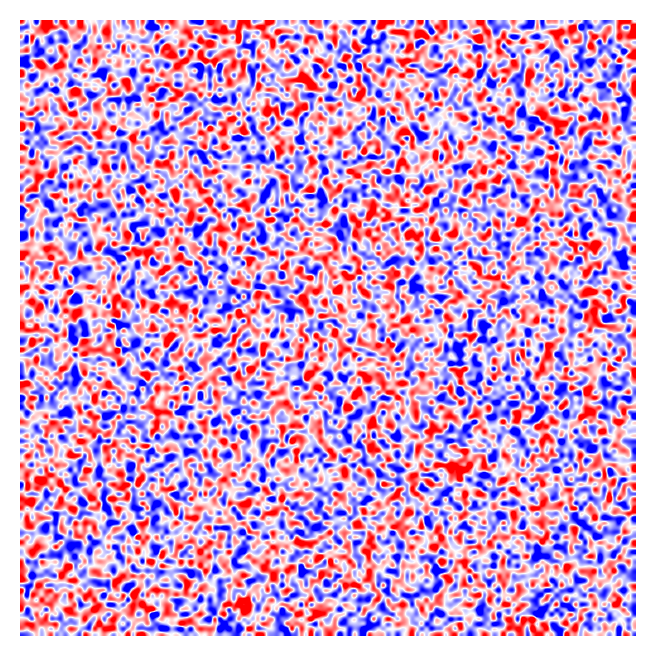

In [92]:
# white noise
f = plt.figure(figsize=(4,4))
im = np.random.randn(128,128)
plt.imshow(im, cmap='bwr', vmin=-1, vmax=1, interpolation='gaussian')
plt.axis('off')

(-0.5, 255.5, -0.5, 255.5)

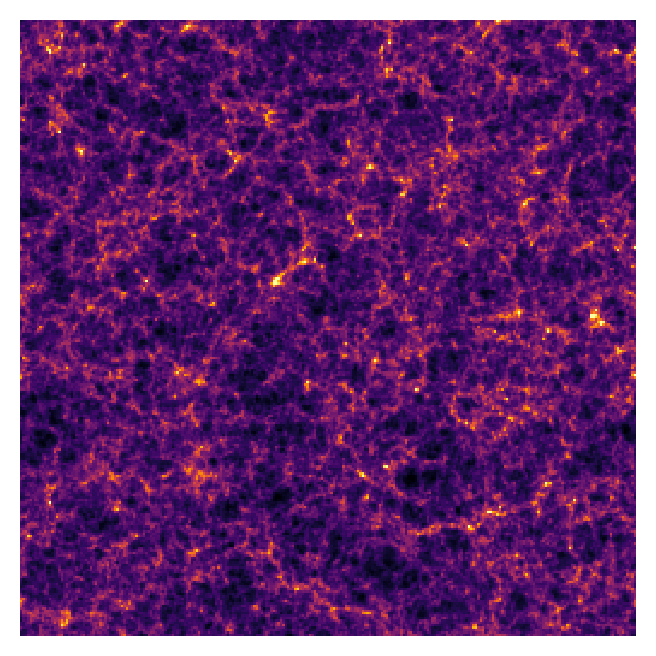

In [134]:
# nbody output
lhid=0
simdir = f'/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm/L2000-N256/{lhid}'
with h5py.File(join(simdir, 'nbody.h5'), 'r') as f:
    a = list(f.keys())[5]
    rho = f[a]['rho'][...]

f = plt.figure(figsize=(4,4))
x = np.mean(rho[50:65], axis=0).T
plt.imshow(x, cmap='inferno', vmax=2, interpolation='nearest')
plt.axis('off')


(0.0, 2000.0)

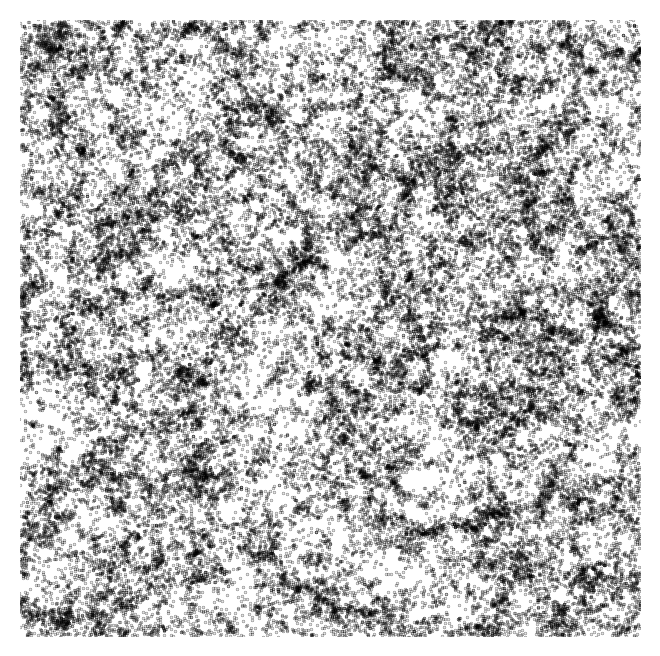

In [135]:
# halo output
with h5py.File(join(simdir, 'halos.h5'), 'r') as f:
    a = list(f.keys())[5]
    pos = f[a]['pos'][...]

f = plt.figure(figsize=(4,4))
imin, imax = 50, 65
imin, imax = imin/256*2000, imax/256*2000
mask = (pos[:,0] > imin) & (pos[:,0] < imax)
x = deepcopy(pos[mask])
x += np.random.randn(*x.shape)*8/np.sqrt(3)

plt.plot(x[:,1], x[:,2], '.', markersize=0.3, alpha=0.7, color='k')
plt.axis('off')
plt.xlim(0,2000)
plt.ylim(0,2000)

(0.0, 2000.0)

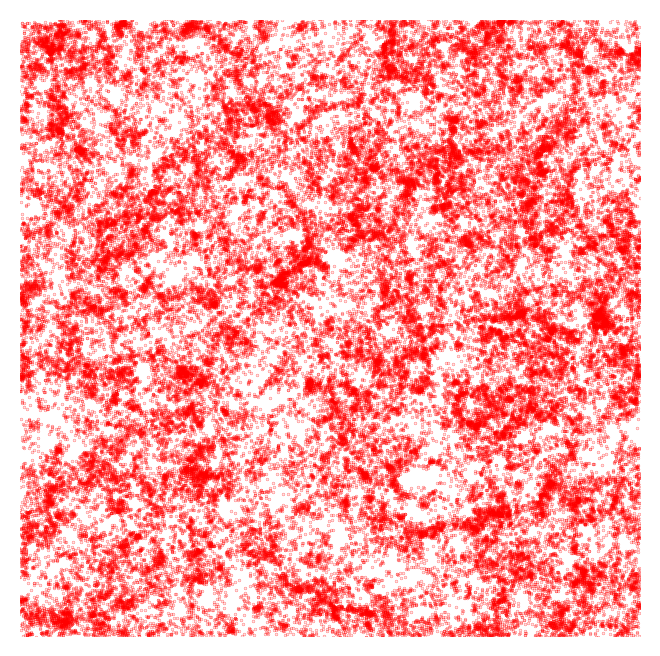

In [136]:
# galaxy output
with h5py.File(join(simdir, 'galaxies/hod00000.h5'), 'r') as f:
    a = list(f.keys())[5]
    pos = f[a]['pos'][...]

f = plt.figure(figsize=(4,4))
imin, imax = 50, 65
imin, imax = imin/256*2000, imax/256*2000
mask = (pos[:,0] > imin) & (pos[:,0] < imax)
x = deepcopy(pos[mask])
x += np.random.randn(*x.shape)*8/np.sqrt(3)

plt.plot(x[:,1], x[:,2], '.', markersize=0.3, alpha=0.7, color='r')
plt.axis('off')
plt.xlim(0,2000)
plt.ylim(0,2000)

In [137]:
simdir

'/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm/L2000-N256/0'

In [208]:
# galaxy lightcone
from cmass.survey.ngc_selection import load_galaxies, remap, move_to_footprint, xyz_to_sky, sky_to_xyz, BOSS_redshift, BOSS_angular, BOSS_veto
from cmass.utils import load_params

# Load galaxies
lhid = 1
source_path = f'/anvil/scratch/x-mho1/cmass-ili/inf_3gpch/borgpm/L3000-N384/{lhid}'
cosmo = load_params(lhid, '/home/x-mho1/git/ltu-cmass/params/latin_hypercube_params.txt')
pos, vel, _ = load_galaxies(source_path, 1/(1+0.5), 0)

# Apply cuboid remapping
u1= [1,1,0]
u2= [0,0,1]
u3= [1,0,0]
pos, vel = remap(
    pos, vel, 3000,
    u1, u2, u3)

# Rotate and shift to align with CMASS
pos, vel = move_to_footprint(
    pos, vel, [184.83975076425324, 34.03863916513374, 0.4194598771198273], cosmo, 3000)

# Calculate sky coordinates
rdz = xyz_to_sky(pos, vel, cosmo)

rangera = [110, 260]
rangedec = [-1, 70]
z_range = [0.4, 0.7]
mask = (rdz[:,0] > rangera[0]) & (rdz[:,0] < rangera[1]) & (rdz[:,1] > rangedec[0]) & (rdz[:,1] < rangedec[1]) & (rdz[:,2] > z_range[0]) & (rdz[:,2] < z_range[1])
rdz = rdz[mask]

mask = BOSS_redshift(rdz[:,2])
rdz = rdz[mask]

mask = BOSS_angular(rdz[:,0], rdz[:,1], wdir='/anvil/scratch/x-mho1/cmass-ili')
rdz = rdz[mask]

mask = BOSS_veto(rdz[:,0], rdz[:,1], wdir='/anvil/scratch/x-mho1/cmass-ili')
rdz = rdz[~mask]

xyz = sky_to_xyz(rdz, cosmo)

[02:45:01-INFO] Running remap...
[02:45:01-INFO] Remapping from [3000, 3000, 3000] to [4242.640687119286, 3000.0, 2121.320343559643].
/anvil/projects/x-phy240043/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
[02:45:03-INFO] Finished remap... (0m1s)
[02:45:03-INFO] Running move_to_footprint...
[02:45:06-INFO] Finished move_to_footprint... (0m3s)


/tmp/ipykernel_2060280/2562711359.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('viridis')


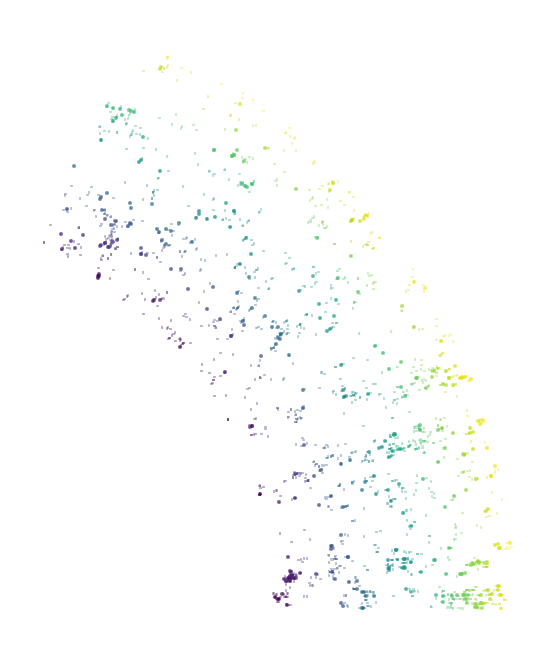

In [205]:
ix, dx = 0, 100
mask = (xyz[:,1] > 0) & (xyz[:,1] < dx)
f, ax = plt.subplots(1,1, figsize=(4,4))

cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=0.4, vmax=0.7)
colors = cmap(norm(rdz[mask,2]))
ax.scatter(-xyz[mask,0], xyz[mask,2], marker=',', s=0.01, alpha=0.7, c=colors)
ax.axis('off')
ax.set_aspect('equal')
ax.set_facecolor('black')

(102.50197296445918, 267.47710389729417, -4.482818415414115, 72.21207533979963)

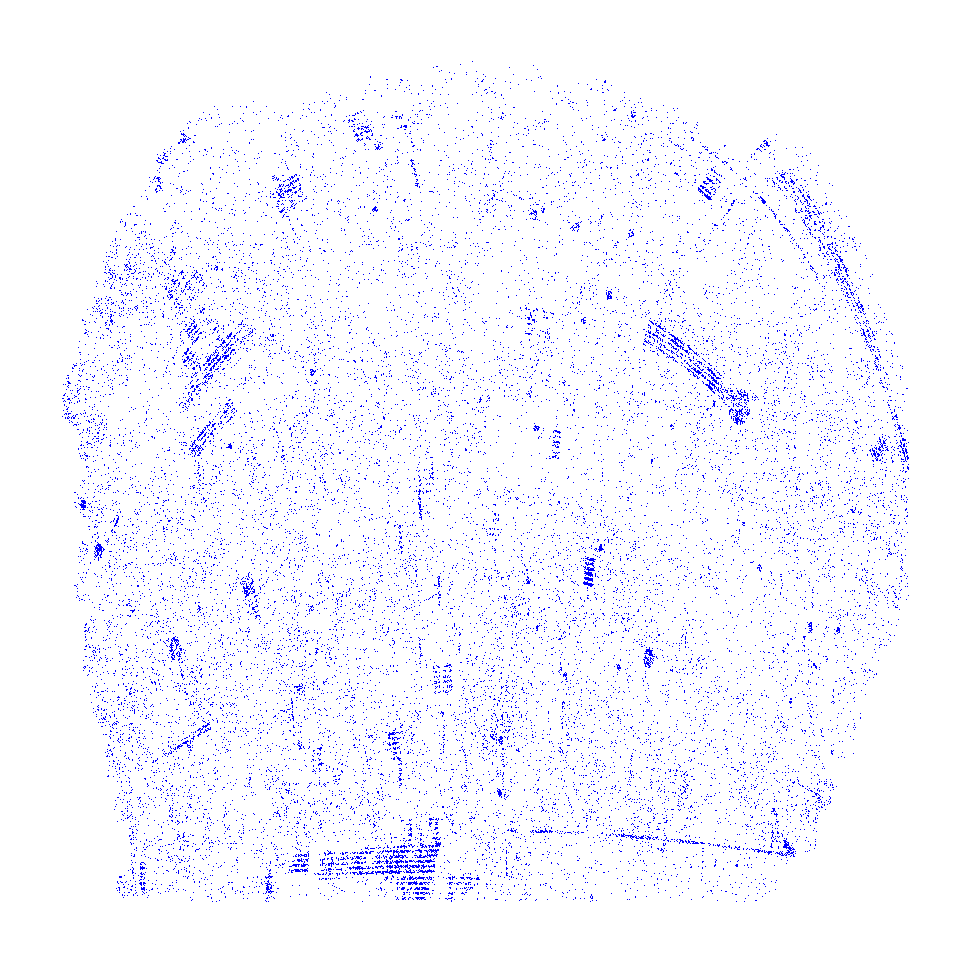

In [206]:
dx = 0.1
mask = np.abs(rdz[:,2] -0.5) < dx

f, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(rdz[mask,0], rdz[mask,1], ',', alpha=1, color='b')
ax.axis('off')